<a href="https://colab.research.google.com/github/edisonmoy/Textualism/blob/master/Model_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Compare w2v models
Alex and Javed trained four different w2v models. We will analyze the word embeddings of each, particularly with gendered words, and compare results. 

## Load Models

In [ ]:
# Load model
import os
from google.colab import drive
from gensim.models import Word2Vec

# Suppress warnings (dangerous)
import warnings
warnings.filterwarnings("ignore")

drive.mount('/content/drive', force_remount=True)
model_path = "drive/My Drive/Textualism/Edison + Ritvik Notebooks/models/"

models = []
for filename in os.listdir(model_path):
    if filename.endswith("model"): 
        temp = Word2Vec.load(model_path + filename)
        print(temp)
        models.append(temp)

print("Number of models loaded: "+ str(len(models)))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Word2Vec(vocab=237339, size=50, alpha=0.025)
Word2Vec(vocab=237339, size=50, alpha=0.025)
Word2Vec(vocab=237339, size=50, alpha=0.025)
Word2Vec(vocab=237339, size=50, alpha=0.025)
Number of models loaded: 4


In [ ]:
# Sanity check: compare similarity of words
import IPython
import numpy as np
from tabulate import tabulate
import pandas as pd
import seaborn as sns; sns.set()

# Columnns = y , Rows = x
y = ['man', 'woman','convict', 'criminal']
x = ['her', 'she', 'his', 'him', 'president', 'judge', 'innocent', 'guilty', 'liberal', 'conservative', 'democrat', 'republican', 'criminal']



def color_columns(x):
  colors = [ "#D9F0FF","#9F9FED", "#FFC4D1", "#FFE8E1", "#D4DCCD"]
  df = x.copy()
  i = 0
  for column in x:
    df[[column]] = 'background-color: %s' %colors[i // (len(models)+1)]
    i+=1
    if "Average" in column:
      df[[column]] = 'background-color: #FDF15A'
  return df    

data = []
avg_diff = 0
for i in x:
  row = []
  for j in y:
    sum = 0
    max = -2
    min = 2
    for model in models:
      similarity_score = model.wv.similarity(i,j) 
      if similarity_score > max: max = similarity_score
      if similarity_score < min: min = similarity_score 
      row.append(similarity_score)
      sum += similarity_score
    avg_diff += (max - min)
    row.append(sum / len(models))
  data.append(row)

avg_diff /= len(y)* len(x)
print("Average difference in similarity between models: "+str(avg_diff))

columns = ["Model " + str(x[1]%(len(models)+1)) +": "+ x[0] if x[1] % (len(models) + 1) != 4 else "Average: "+ x[0] for x in (zip(np.repeat(y, len(models)+1), range(len(y) * (len(models)+1))))]
df = pd.DataFrame(data, index=x, columns=columns).style.apply(color_columns, axis=None)
IPython.display.HTML(df.render())

# sns.heatmap(pd.DataFrame(data, index=x, columns=columns))


Average difference in similarity between models: 0.03891071852726432


,Model 0: man,Model 1: man,Model 2: man,Model 3: man,Average: man,Model 0: woman,Model 1: woman,Model 2: woman,Model 3: woman,Average: woman,Model 0: convict,Model 1: convict,Model 2: convict,Model 3: convict,Average: convict,Model 0: criminal,Model 1: criminal,Model 2: criminal,Model 3: criminal,Average: criminal
her,0.366461,0.385668,0.382188,0.398274,0.383148,0.490642,0.491283,0.508379,0.527717,0.504505,0.217909,0.228764,0.240181,0.220667,0.226880,-0.028796,-0.019890,-0.020479,-0.036214,-0.026344
she,0.540753,0.556126,0.545065,0.559865,0.550452,0.602281,0.598803,0.583668,0.587271,0.593006,0.267138,0.280167,0.297152,0.260294,0.276188,-0.032398,-0.036833,-0.032209,-0.060771,-0.040552
his,0.300059,0.310282,0.302865,0.295016,0.302056,0.359263,0.367127,0.368028,0.377201,0.367905,0.326030,0.311475,0.343889,0.338481,0.329969,0.154200,0.143014,0.152586,0.134214,0.146003
him,0.504557,0.502111,0.506293,0.508212,0.505293,0.531917,0.509946,0.550900,0.535343,0.532027,0.365900,0.377356,0.394440,0.387543,0.381310,0.261325,0.284506,0.254475,0.258150,0.264614
president,0.299538,0.307547,0.280606,0.313698,0.300347,0.288465,0.271636,0.275430,0.247953,0.270871,-0.019719,-0.015073,0.031235,0.005584,0.000507,0.036667,0.030508,0.022565,0.031270,0.030252
judge,0.354532,0.334726,0.346573,0.322100,0.339483,0.297054,0.296677,0.299968,0.262384,0.289021,0.273922,0.314892,0.332760,0.290201,0.302944,0.262080,0.258939,0.300650,0.279098,0.275192
innocent,0.547542,0.525912,0.548537,0.518314,0.535076,0.477638,0.474420,0.453300,0.453218,0.464644,0.501022,0.510319,0.478863,0.479175,0.492345,0.499617,0.474798,0.452569,0.491513,0.479624
guilty,0.336479,0.315645,0.331902,0.320255,0.326070,0.259466,0.265367,0.268239,0.265009,0.264520,0.639511,0.622191,0.616408,0.618481,0.624148,0.365257,0.281762,0.330238,0.329438,0.326674
liberal,-0.165709,-0.164229,-0.166533,-0.157203,-0.163418,-0.175677,-0.131463,-0.149062,-0.126285,-0.145622,-0.243118,-0.236792,-0.272576,-0.252334,-0.251205,0.041557,0.161077,0.046004,0.101296,0.087484
conservative,-0.026097,-0.070750,-0.082342,-0.099530,-0.069680,-0.016161,-0.071412,-0.141731,-0.072378,-0.075421,-0.249648,-0.212541,-0.236923,-0.258653,-0.239441,-0.118605,-0.089373,-0.044989,-0.096356,-0.087331


### Analysis

From our sanity check, we checked the similarity scores between words across models. Some interesting observations include:

- **criminal** is more similar to **innocent** than **guilty**
- **woman** is more similar to **him** than **her**

## Visualizing senitment sums of opposite words

Opposite words, when compared with any other word, should have a sum of 1.
For example:
- (woman vs win) + (woman vs lose) = 1
- (man vs guilty) + (man vs innocent) = 1

Since these do not always sum approx to 1, here are some visualizations to suggest constraints on the model.

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


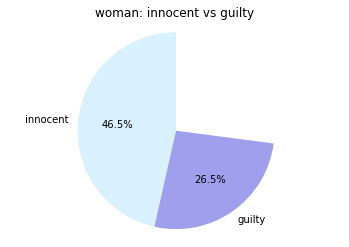

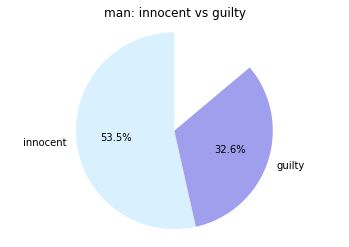

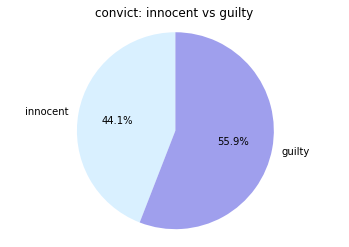

In [ ]:
import matplotlib.pyplot as plt

def compare_and_pie(opposite_words, reference_list):
  for reference in reference_list:
    value_avg = []
    for opp in opposite_words:
      total = 0
      for model in models:
        total += model.wv.similarity(opp,reference)
      value_avg.append(total/len(models))
    fig1, ax1 = plt.subplots()
    ax1.pie(value_avg, labels=[x for x in opposite_words], colors=[ "#D9F0FF","#9F9FED"],autopct='%1.1f%%', startangle=90)
    ax1.axis('equal')
    plt.title(reference+": " + opposite_words[0] +" vs " + opposite_words[1])
    plt.show()

compare_and_pie(("innocent", "guilty"), ["woman","man", "convict"])

## Gender Bias Analysis


### Create femininity vector for each model
Average the word embeddings of the feminine words to create femininty vector. Compare across models.

In [ ]:
def average_vector(word_list, model):
  vector = np.zeros(model[word_list[0]].shape)
  for word in word_list:
    vector += model[word]
  vector /= len(word_list)
  return vector

feminine_words = ['women', 'woman', 'her', 'herself', 'she', 'female']

i = 0
for model in models:
  femininity_vector = average_vector(feminine_words, model)
  data = model.most_similar(positive=[femininity_vector], topn=10)
  df = pd.DataFrame(data, columns=["Top feminine words", "Cosine similarity"])
  print("Most similar words: Model " + str(i))
  i+=1
  print(df)
  print("\n")

Most similar words: Model 0
  Top feminine words  Cosine similarity
0                she           0.836444
1              woman           0.820290
2                her           0.817892
3             female           0.801168
4               baby           0.787102
5             mother           0.779422
6             father           0.776305
7            mother,           0.764695
8             worker           0.764375
9                 he           0.762418


Most similar words: Model 1
  Top feminine words  Cosine similarity
0                she           0.831981
1                her           0.825140
2              woman           0.817358
3             female           0.813467
4               her,           0.790902
5             mother           0.770231
6            mother,           0.761967
7             father           0.754457
8                 he           0.749409
9               girl           0.748528


Most similar words: Model 2
  Top feminine words  Cosine sim

### Analysis
Many of the seed words used to generate the femininity vector are 